## Research Questions

### Business Question
•	What steps can we take to enhance our recommendation algorithm to provide better advice to stand-up comedians on which jokes to use to optimize audience engagement?


### Sub-questions
1. Which features are suitable for building our recommenders system?
2. Is it possible to make predictions what ratings users will give to jokes they never heard before? 
3. Which collaborative filtering technique (SVD or KNN) is most suitable to improve our recommenders system??



# We import our packages 

In [2]:
import pandas as pd              #this library was used to read the CSV file
import numpy as np               #this library was used for mathematical purposes
#import researchpy as rp          #this library was used to visualize tables
import matplotlib.pyplot as plt  #this library was used to plot graphs
import seaborn as sns            #this library was used for visualizations (histograms, boxplots and lineplots)
import scipy.stats as stats      #this library was used to perform T-tests
import statsmodels.api as sm     #this library was used to perform Anova testing
from statsmodels.formula.api import ols #this library was used to perform Anova testing
from zipfile import ZipFile
import os  


%pip install scikit-surprise
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

import tarfile
os.chdir
os.getcwd()


Note: you may need to restart the kernel to use updated packages.


'c:\\Users\\rensi\\OneDrive\\Documenten\\python project\\System Development for Marketing (RecSys)\\Jester'

# We import both CSV files and merge them together

In [4]:
#Read original CSV file; Themepark posts part I (uncleaned data)
df_Jester1 = pd.read_csv("jester_items.csv", sep=",", encoding='cp1252')
df_Jester1

jokeId                                           jokeText
0         1  A man visits the doctor. The doctor says "I ha...
1         2  This couple had an excellent relationship goin...
2         3  Q. What's 200 feet long and has 4 teeth? \n\nA...
3         4  Q. What's the difference between a man and a t...
4         5  Q.\tWhat's O. J. Simpson's Internet address? \...
..      ...                                                ...
145     146  America: 8:00 - Welcome to work! 12:00 - Lunch...
146     147  It was the day of the big sale. Rumors of the ...
147     148  Recently a teacher, a garbage collector, and a...
148     149  A little girl asked her father, "Daddy? Do all...
149     150  In an interview with David Letterman, Carter p...

[150 rows x 2 columns]

In [5]:
#Read original CSV file; Themepark posts part I (uncleaned data)
df_Jester2 = pd.read_csv("jester_ratings.csv", sep=",", encoding='cp1252')
df_Jester2

userId  jokeId  rating
0             1       5   0.219
1             1       7  -9.281
2             1       8  -9.281
3             1      13  -6.781
4             1      15   0.875
...         ...     ...     ...
1761434   63978      57  -8.531
1761435   63978      24  -9.062
1761436   63978     124  -9.031
1761437   63978      58  -8.656
1761438   63978      44  -8.438

[1761439 rows x 3 columns]

In [6]:
df_Jester2['rating'].describe()

count    1.761439e+06
mean     1.618602e+00
std      5.302608e+00
min     -1.000000e+01
25%     -2.031000e+00
50%      2.219000e+00
75%      5.719000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [7]:
# Samenvoegen van de twee dataframes op basis van de kolom 'jokeId'
df_merged = pd.merge(df_Jester1, df_Jester2, on='jokeId')
df_merged.head()

jokeId                                           jokeText  userId  rating
0       5  Q.\tWhat's O. J. Simpson's Internet address? \...       1   0.219
1       5  Q.\tWhat's O. J. Simpson's Internet address? \...       2  -9.688
2       5  Q.\tWhat's O. J. Simpson's Internet address? \...       3  -9.844
3       5  Q.\tWhat's O. J. Simpson's Internet address? \...       4  -5.812
4       5  Q.\tWhat's O. J. Simpson's Internet address? \...       5   6.906

In [57]:
df_merged["rating"].describe()

count    1.761439e+06
mean     1.618602e+00
std      5.302608e+00
min     -1.000000e+01
25%     -2.031000e+00
50%      2.219000e+00
75%      5.719000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [58]:
# Group by 'jokeId' and calculate mean rating
df_mean_rating = df_merged.groupby('jokeId')['rating'].mean().reset_index()

# Sort by mean rating in descending order
df_mean_rating_sorted = df_mean_rating.sort_values(by='rating', ascending=False)

# Print the top 10 highest rated jokes
print(df_mean_rating_sorted.head(10))

     jokeId    rating
42       53  3.714381
94      105  3.711223
78       89  3.606506
118     129  3.583496
24       35  3.560305
61       72  3.505712
21       32  3.504739
93      104  3.422796
57       68  3.387269
95      106  3.337933


In [6]:
df_merged.head()

jokeId                                           jokeText  userId  rating
0       5  Q.\tWhat's O. J. Simpson's Internet address? \...       1   0.219
1       5  Q.\tWhat's O. J. Simpson's Internet address? \...       2  -9.688
2       5  Q.\tWhat's O. J. Simpson's Internet address? \...       3  -9.844
3       5  Q.\tWhat's O. J. Simpson's Internet address? \...       4  -5.812
4       5  Q.\tWhat's O. J. Simpson's Internet address? \...       5   6.906

In [7]:
df_merged.shape

(1761439, 4)

## No data cleaning needed

In [8]:
# Looking for missing values
print(df_merged.isna().sum()) # count of missing values
print(df_merged.isnull().sum()) # count of missing values
final_df = df_merged.dropna() # removing rows with missing values

jokeId      0
jokeText    0
userId      0
rating      0
dtype: int64
jokeId      0
jokeText    0
userId      0
rating      0
dtype: int64


## We start the Exploratory Data analysis (EDA)

In [59]:
print("Number of unique users: ", df_merged["userId"].value_counts().count())
print("Number of unique jokes: ", df_merged["jokeId"].value_counts().count())
print("Total number of ratings: ", df_merged.count())

Number of unique users:  59132
Number of unique jokes:  140
Total number of ratings:  jokeId      1761439
jokeText    1761439
userId      1761439
rating      1761439
dtype: int64


#### * We will use a counplot to get a sense of how the ratings are distributed

- Conclusion; The most users in the dataset rated the jokes 0.0 or higher.

C:\Users\rensi\AppData\Local\Temp\ipykernel_17512\453753310.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_merged['rating'], kde=False, bins=8, hist_kws=dict(edgecolor="k", linewidth=2))


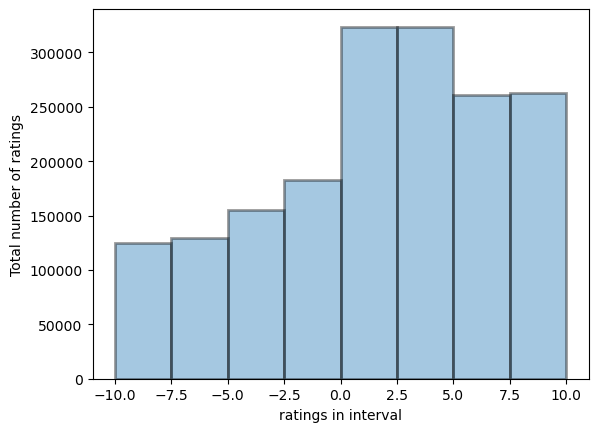

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(df_merged['rating'], kde=False, bins=8, hist_kws=dict(edgecolor="k", linewidth=2))

ax = plt.gca()  # get current axis
ax.set_xlabel("ratings in interval")
ax.set_ylabel("Total number of ratings")

plt.show()

In [9]:
df_merged.head()

jokeId                                           jokeText  userId  rating
0       5  Q.\tWhat's O. J. Simpson's Internet address? \...       1   0.219
1       5  Q.\tWhat's O. J. Simpson's Internet address? \...       2  -9.688
2       5  Q.\tWhat's O. J. Simpson's Internet address? \...       3  -9.844
3       5  Q.\tWhat's O. J. Simpson's Internet address? \...       4  -5.812
4       5  Q.\tWhat's O. J. Simpson's Internet address? \...       5   6.906

##### * Ploting the 5 most frequent & less frequent rated jokes in the dataset



([0, 1, 2, 3, 4],
 [Text(0, 0, 'Q. What is orange and sounds like a parrot?  \n\nA. A carrot.\n'),
  Text(0, 1, 'Q:  What did the blind person say when given some matzah?\n\nA:  Who the hell wrote this?\n'),
  Text(0, 2, 'They asked the Japanese visitor if they have elections in his\ncountry.  \n"Every Morning" he answers.\n'),
  Text(0, 3, 'Q. Did you hear about the dyslexic devil worshiper? \n\nA. He sold his soul to Santa.\n'),
  Text(0, 4, "How many feminists does it take to screw in a light bulb?\nThat's not funny.\n")])

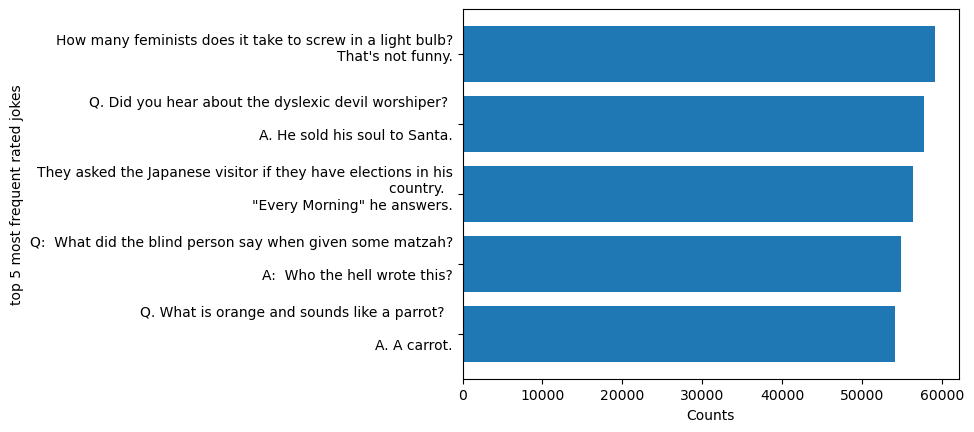

In [15]:
# The top 15 most frequent rated jokes
jokes_counts = df_merged['jokeText'].value_counts()

# top 5 jokes
n = 5

# selecting top 15 most frequent rated jokes
top_jokes = jokes_counts[:n]


# descending order
top_jokes = top_jokes.iloc[::-1]

# create horizontal diagram
fig, ax = plt.subplots()
bars = ax.barh(top_jokes.index, top_jokes.values)

# adding labels
plt.ylabel("top 5 most frequent rated jokes")
plt.xlabel("Counts")

# rotate  y-axis labels 
plt.yticks(rotation=0)

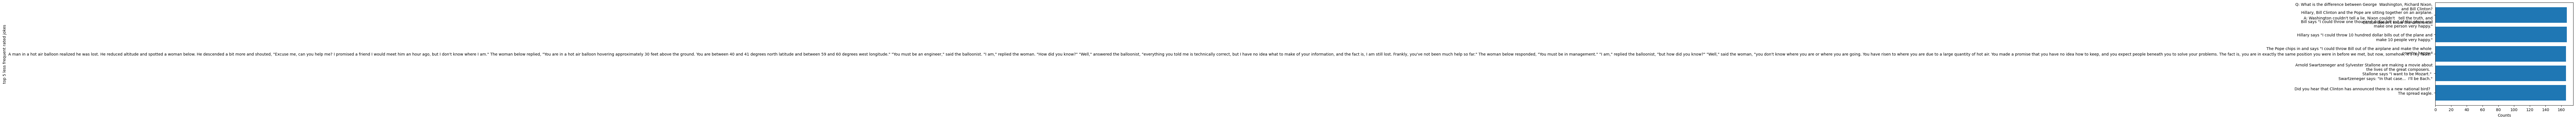

In [19]:
# Amount of unique rated jokes by users
jokes_counts = df_merged['jokeText'].value_counts()

# bottom 5 jokes
n = 5

# selecting bottom 5 less frequent rated jokes
bottom_jokes = jokes_counts[-n:]

# descending order
bottom_jokes = bottom_jokes.iloc[::-1]

# create horizontal diagram
fig, ax = plt.subplots()
bars = ax.barh(bottom_jokes.index, bottom_jokes.values)

# aaing labels
plt.ylabel("top 5 less frequent rated jokes")
plt.xlabel("Counts")

# rotate y-axis labels
plt.yticks(rotation=0)


plt.show()






plt.show()

In [21]:
df_merged.head()

jokeId                                           jokeText  userId  rating
0       5  Q.\tWhat's O. J. Simpson's Internet address? \...       1   0.219
1       5  Q.\tWhat's O. J. Simpson's Internet address? \...       2  -9.688
2       5  Q.\tWhat's O. J. Simpson's Internet address? \...       3  -9.844
3       5  Q.\tWhat's O. J. Simpson's Internet address? \...       4  -5.812
4       5  Q.\tWhat's O. J. Simpson's Internet address? \...       5   6.906

#### Distribution of Ratings per Joke

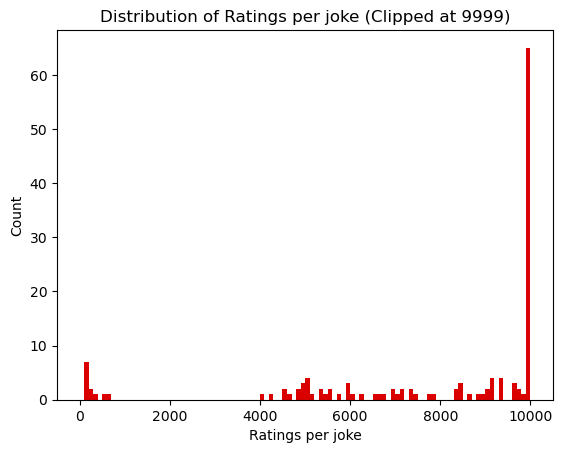

In [24]:
# Ratings per joke
data_joke = df_merged['jokeId'].value_counts().clip(upper=9999)
plt.hist(data_joke, bins=100, range=(0, 10000), color='#db0000')
plt.title('Distribution of Ratings per joke (Clipped at 9999)')
plt.xlabel('Ratings per joke')
plt.ylabel('Count')
plt.show()

#### Plot that shows the distribtuion of Ratings per user

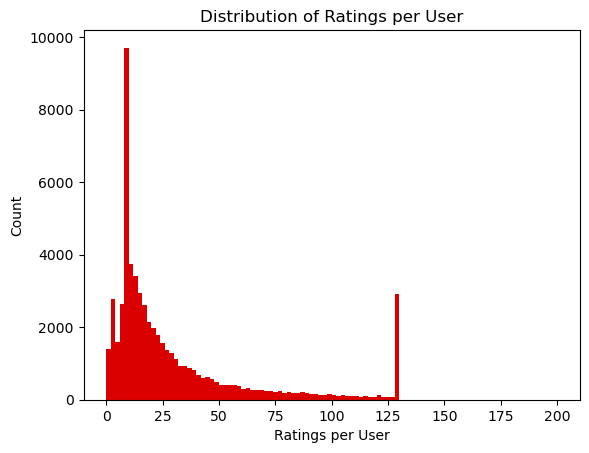

In [60]:
# Ratings per user
data_user = df_merged['userId'].value_counts().clip(upper=199)
plt.hist(data_user, bins=100, range=(0, 200), color='#db0000')
plt.title('Distribution of Ratings per User')
plt.xlabel('Ratings per User')
plt.ylabel('Count')
plt.show()

#### Ratings distribution with describe function

In [61]:
ratings_per_user = df_merged.groupby('userId').agg({"rating":"count"})
ratings_per_user.describe()

rating
count  59132.000000
mean      29.788253
std       32.801761
min        1.000000
25%        8.000000
50%       16.000000
75%       36.000000
max      140.000000

In [62]:
df_merged['rating'].describe()

count    1.761439e+06
mean     1.618602e+00
std      5.302608e+00
min     -1.000000e+01
25%     -2.031000e+00
50%      2.219000e+00
75%      5.719000e+00
max      1.000000e+01
Name: rating, dtype: float64

## Slicing the data; 
Reducing the dataset in size will help us load the data quicker, since this dataset is huge. Additionally this will improve the efficiency and statistical significance of this model.
- Conclusion 1: We will remove the jokes with too little reviews
- Conclusion 2: We will remove customers who give too little reviews
- They will removed because they are not as relevant as the popular and active customers in this dataset.

In [8]:
# Count the number of ratings per user
user_counts = df_merged['userId'].value_counts()

# Print the number of users with less than 10 ratings
print("Number of users with less than 10 ratings:", len(user_counts[user_counts < 10]))

Number of users with less than 10 ratings: 18130


In [64]:
# Count the number of ratings per joke
joke_counts = df_merged['jokeId'].value_counts()

# Get the indices of jokes with less than 10 ratings
less_than_10 = joke_counts.index[joke_counts < 10]

# Print the number of jokes with less than 10 ratings
print("Number of jokes with less than 10 ratings:", len(less_than_10))

Number of movies with less than 10 ratings: 0


In [25]:
# Count the number of ratings per user
user_counts = df_merged['userId'].value_counts()

# Count the number of ratings per joke
joke_counts = df_merged['jokeId'].value_counts()

# Slice final_df to keep only data with at least 10 ratings per user and per joke
df_merged = df_merged[df_merged['userId'].isin(user_counts[user_counts >= 10].index)]
df_merged = df_merged[df_merged['jokeId'].isin(joke_counts[joke_counts >= 10].index)]

Conclusion: Looking at the distribution plot of user ratings, you will see the users who rated less then 10 jokes are being dropped now.

C:\Users\rensi\AppData\Local\Temp\ipykernel_14392\660156077.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_merged.corr()


          jokeId    userId    rating
jokeId  1.000000  0.007793  0.163052
userId  0.007793  1.000000  0.020411
rating  0.163052  0.020411  1.000000


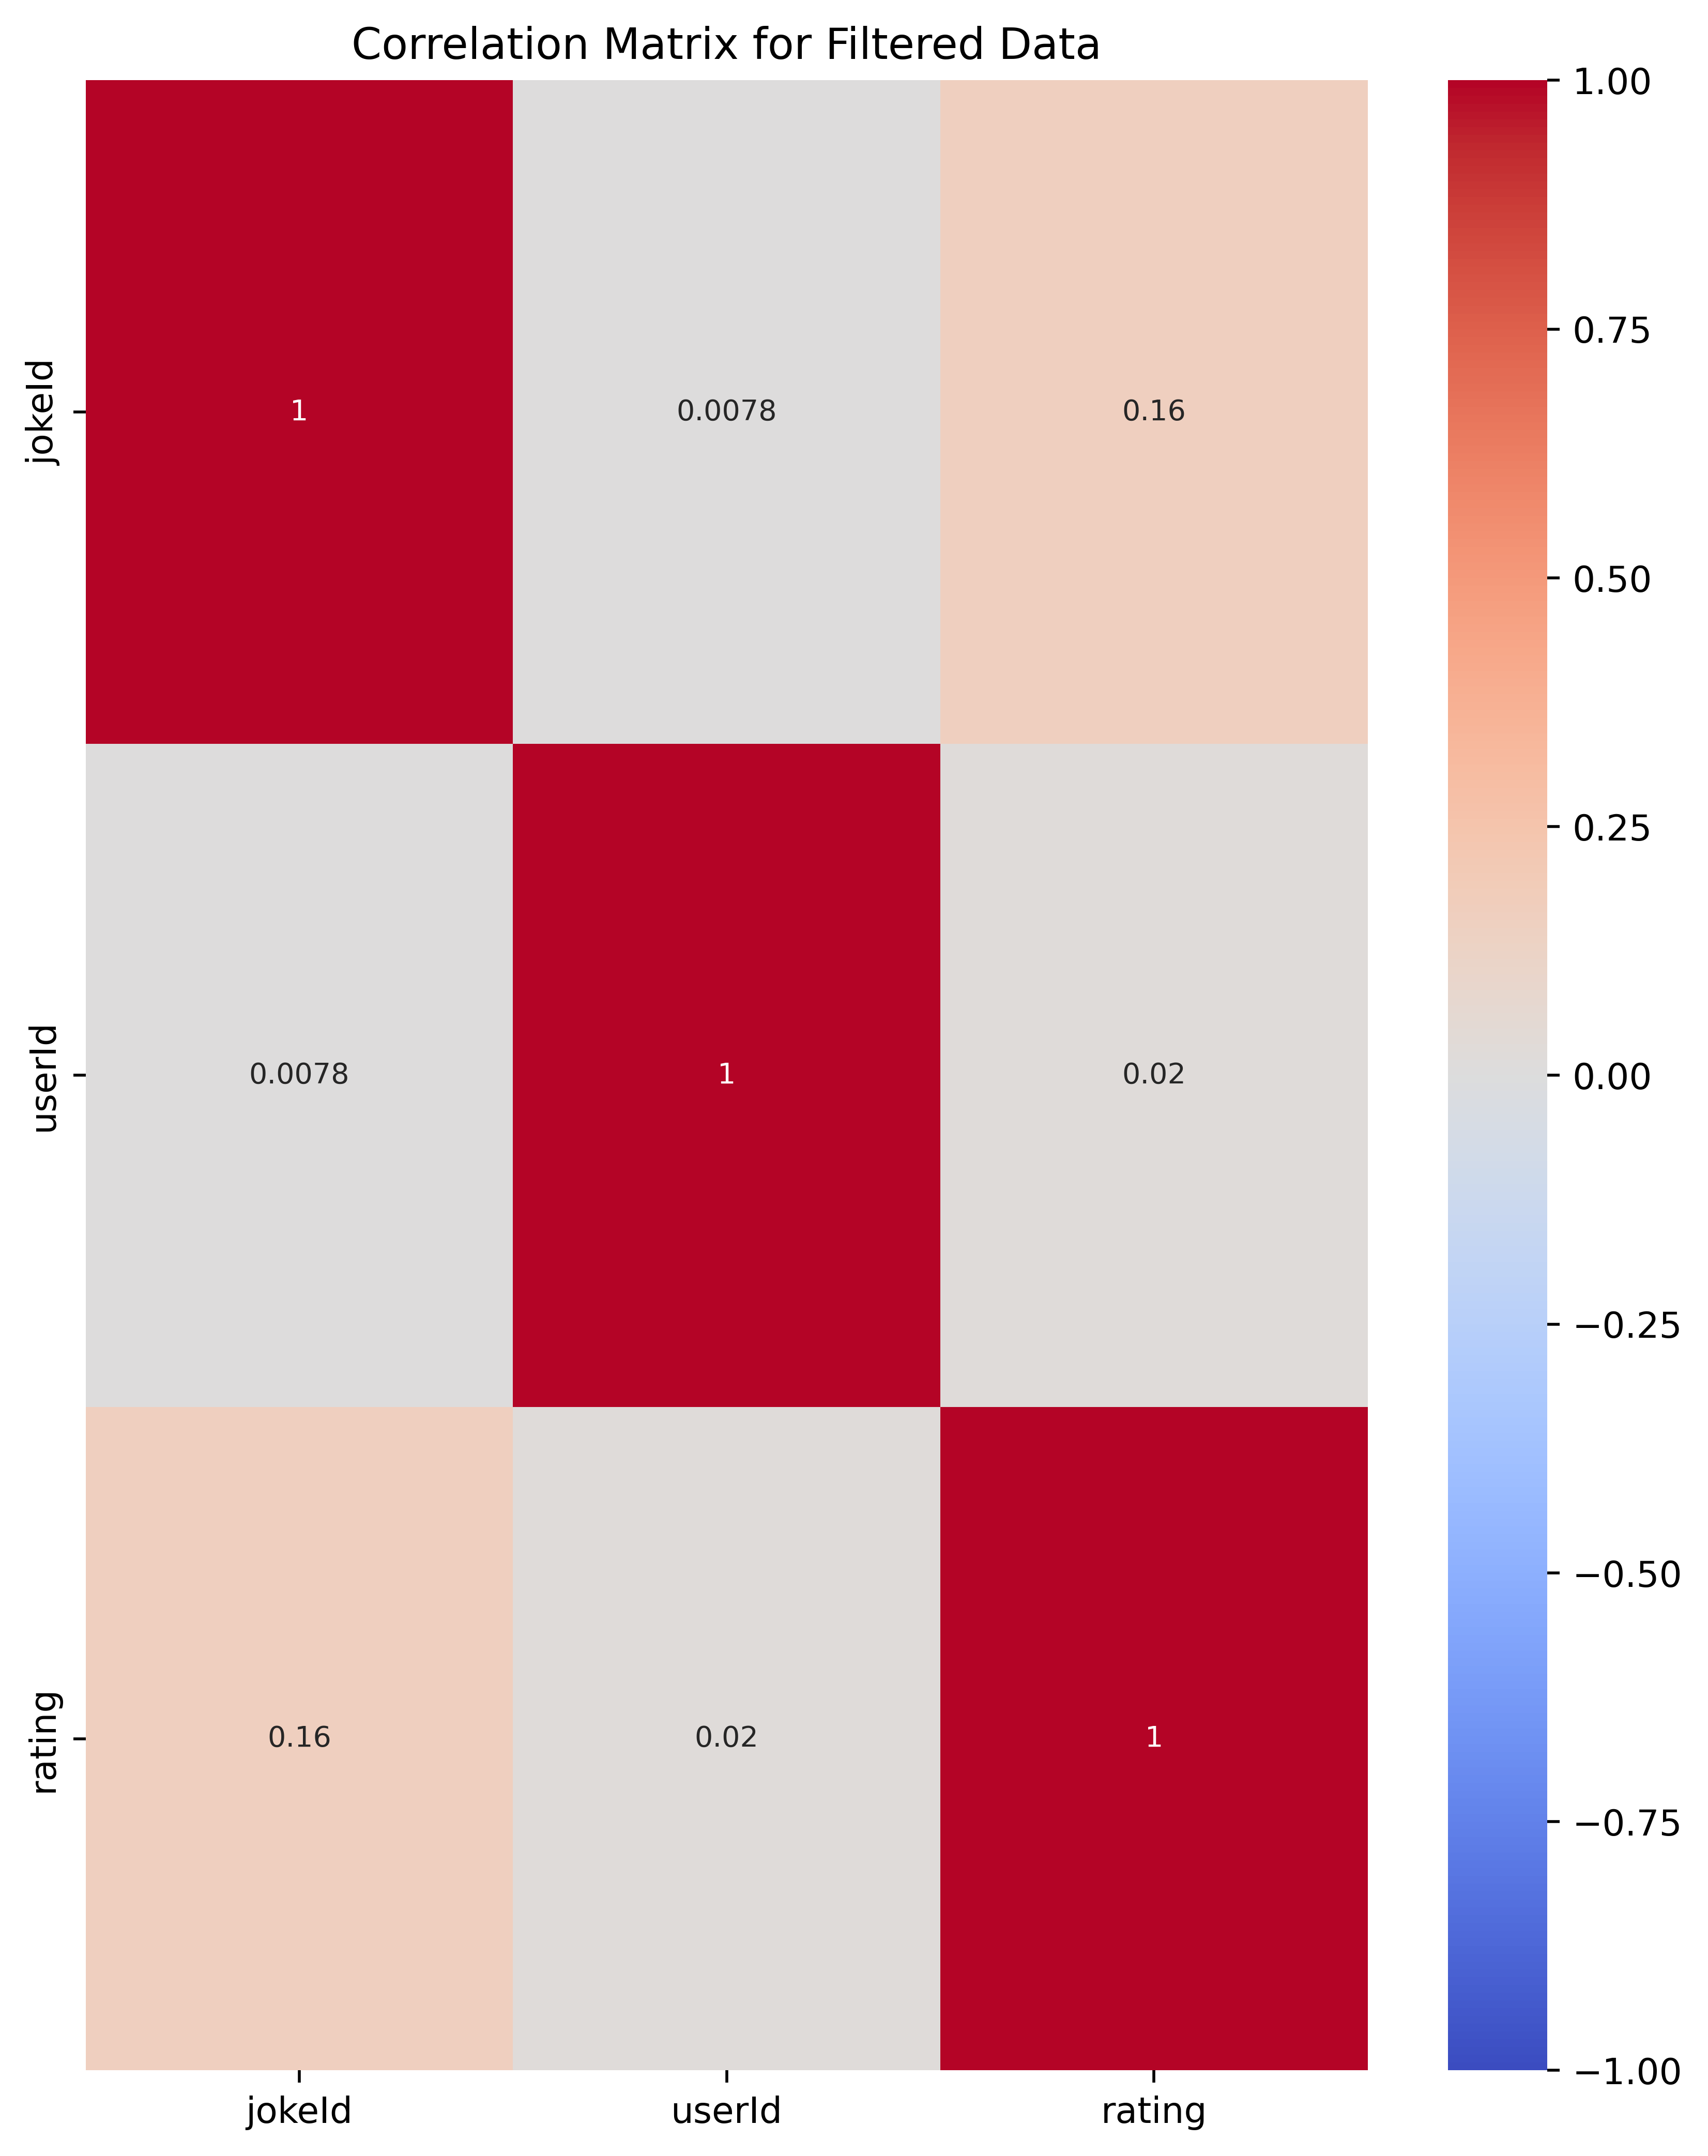

In [26]:
# Calculate correlation matrix for the filtered_data DataFrame
correlation_matrix = df_merged.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
fig, ax = plt.subplots(figsize=(8, 10), dpi=500)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax, annot_kws={'fontsize': 8})

# Set the title for the heatmap
ax.set_title('Correlation Matrix for Filtered Data')

plt.show()

In [27]:
df_merged.head()

jokeId                                           jokeText  userId  rating
0       5  Q.\tWhat's O. J. Simpson's Internet address? \...       1   0.219
1       5  Q.\tWhat's O. J. Simpson's Internet address? \...       2  -9.688
2       5  Q.\tWhat's O. J. Simpson's Internet address? \...       3  -9.844
4       5  Q.\tWhat's O. J. Simpson's Internet address? \...       5   6.906
5       5  Q.\tWhat's O. J. Simpson's Internet address? \...       6  -0.031

#### Pearson correlation method

Conclusion; There are no significant correlations between the features. 

In [28]:
cont_var = ['jokeId', 'jokeText', 'userId', 'rating']
pearson = df_merged[cont_var].corr(method='pearson')
print(round(pearson,3))

        jokeId  userId  rating
jokeId   1.000   0.008   0.163
userId   0.008   1.000   0.020
rating   0.163   0.020   1.000


C:\Users\rensi\AppData\Local\Temp\ipykernel_14392\2419399548.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson = df_merged[cont_var].corr(method='pearson')


#### Spearman's rank correlation method
 Conclusion; 
- There is slight negative correlation between the 'rating' and jokeId'
- There is no significant correlation between 'JokeId' and 'userid'
- There is no significant correlation between 'rating' and 'userid'


In [30]:
# Checking correlation among the continuous variables using Spearman's rank correlation coefficient

cont_var = ['jokeId', 'jokeText', 'userId', 'rating', ]
df_merged[cont_var].corr(method='spearman')

C:\Users\rensi\AppData\Local\Temp\ipykernel_14392\1129328071.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_merged[cont_var].corr(method='spearman')


jokeId    userId    rating
jokeId  1.000000  0.007233  0.165069
userId  0.007233  1.000000  0.018654
rating  0.165069  0.018654  1.000000

## Collaborative filtering  ~ K-Nearest Neighbors
##### Find similar Jokes based on ratings given by others users (user to user)

KNN;
- This is a filtering machine learning technique for classification or regression. 
- The algorithm will look for the k-nearest data points in the train dataset to ultimately predict the label or value based on the values of the k-nearest neighbor values. 

In [10]:
import pandas as pd
from surprise import Reader, Dataset
from surprise import KNNBasic, SVD
from surprise.model_selection import train_test_split
from scipy.sparse import csr_matrix
import fuzzywuzzy as fuzz  # Package for collection string matching alogorithms 


## KNN step 1) Building a KNN filtering technique for the entire dataset

- KNN = A filtering machine learning technique for classification or regression. 
- The algorithm will look for the k-nearest data points in the train dataset to ultimately predict the label or value based on the values of the k-nearest neighbor values. 
- We will create a pivot table for the features we want to use
- Then, we create a joke_user matrix. The Jokeid's will be on the row side and the userid's will be on the column side. The values to fill this matrix will be the ratings given by all the users. 
(We want to compare jokes based on its ratings)
- Conclusion: We will notice a lot of Nan-values, which means that these  jokes are not rated by the particular users because they have not seen these jokes. 
 Since we can not work with Nan values we will need to fill them with zeros.

  Filling the missing values with zero, since we want to calculate the distances between the rating vectors.


In [74]:
df_merged.pivot_table(index='userId', columns='jokeId', values='rating').fillna(0)


jokeId    5      7      8      13     15     16     17     18     19     20   \
userId                                                                         
1       0.219 -9.281 -9.281 -6.781  0.875 -9.656 -9.031 -7.469 -8.719 -9.156   
2      -9.688  9.938  9.531  9.938  0.406  3.719  9.656 -2.688 -9.562 -9.125   
3      -9.844 -9.844 -7.219 -2.031 -9.938 -9.969 -9.875 -9.812 -9.781 -6.844   
5       6.906  4.750 -5.906 -0.406 -4.031  3.875  6.219  5.656  6.094  5.406   
6      -0.031 -9.094 -0.406  7.500 -7.219 -9.438  0.125 -9.156  3.656 -9.438   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
63966   0.000 -1.750 -0.094  3.750  8.219  6.562  5.094  1.438  3.094  0.000   
63969   0.000 -9.094 -7.375  9.688  8.062 -7.938 -9.781  0.656  0.656  0.000   
63973   0.000 -4.594 -4.312  3.000  3.938 -9.219  8.781  5.219  4.531  0.000   
63974   0.000 -4.438  1.531 -1.438 -9.156 -7.438  2.250  3.750  5.000  0.000   
63978   0.000 -7.906 -7.594 -7.594 -6.375 -6.375 -6.375 -6.375 -1.812  0.000   

jokeId  ...    141    142    143  144    145    146    147    148    149  \
userId  ...                                                                
1       ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
2       ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
3       ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
5       ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
6       ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
...     ...    ...    ...    ...  ...    ...    ...    ...    ...    ...   
63966   ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
63969   ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
63973   ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
63974   ...  0.000  0.000  0.000  0.0  0.000  0.000  0.000  0.000  0.000   
63978   ... -8.312  7.844  8.906  8.5  8.375  8.938  8.281  8.781  8.781   

jokeId    150  
userId         
1       0.000  
2       0.000  
3       0.000  
5       0.000  
6       0.000  
...       ...  
63966   0.000  
63969   0.000  
63973   0.000  
63974   0.000  
63978   7.562  

[41002 rows x 140 columns]

#### We will convert this dataframe into a matrix with the csr matrix functions.
- Transform to spare matrix for more efficient calculations

In [34]:
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix

#create a sparse matrix with the users as rows, the jokes as columns and the ratings as values
sparse_matrix = csr_matrix((df_merged['rating'], (df_merged['userId'], df_merged['jokeId'])))  

In [70]:
from scipy.sparse import csr_matrix

# create a sparse matrix with the users as rows, the jokes as columns, and the ratings as values
sparse_matrix = csr_matrix((df_merged['rating'], (df_merged['userId'], df_merged['jokeId'])))

sparse_matrix

# convert the 'rating' column back to floats
df_merged['rating'] = df_merged['rating'].astype(float)

### KNN step 1) Building a KNN filtering technique 

- The internal process of the KNN model is to find a distance formula to calculate the distances between the different vectors in our dataset.
There are multiple formulas to calculate the distance between two different vectors
- In this model we picked the cosine distance approach

- We use the algorithm = 'brute' in our model. To be able to calculate the distance between one point and all the other points in the matrix, we will need to navigate through all the different vectors to calculate the distance between each of them. 
<br> Brute helps us to take one data point and comparing this point with all the other data points in the dataset (matrix).

- We use n_neigbors to tell the model how many neigbors we want to keep for our recommendations. We choose n_neigbors = 20 , which means we will consider 20 nearest neigbors to predict the new data point.

In [44]:
import pandas as pd
from surprise import Reader, Dataset
from surprise import KNNBasic, SVD
from surprise.model_selection import train_test_split
from scipy.sparse import csr_matrix
import fuzzywuzzy as fuzz  # Package for collection string matching alogorithms 


In [46]:
from sklearn.neighbors import NearestNeighbors
# Create a model to find similar jokes
# We will use the cosine similarity metric to find the nearest neighbors
# We will use the brute force algorithm to find the nearest neighbors
# We will use the 10 nearest neighbors to find the nearest neighbors
#create a KNN model
modelpt = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
modelpt

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

## Step 2) Splitting the recommender system into a training, testing and validation set

- Why splitting our data? Splitting our data will help us overcome overfitting. Overfitting means the ML model learns the patterns in the train data too well, but does not perform well on new unseen data. Specifically overfitting with KNN occurs when the number of neighbors is too small or the distance metrix is not used correctly. To overcome overfitting we split the data in a train, test and validation set


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors # import the NereastNeigbors package for our model creation.

#create a sparse matrix with the users as rows, the jokes as columns and the ratings as values
sparse_matrix = csr_matrix((df_merged['rating'], (final_df['userid'], final_df['jokeid'])))

# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(final_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

# Create sparse matrices for training, validation, and testing data
train_sparse_matrix = csr_matrix((train_data['rating'], (train_data['userid'], train_data['jokeid'])))
val_sparse_matrix = csr_matrix((val_data['rating'], (val_data['userid'], val_data['jokeid'])))
test_sparse_matrix = csr_matrix((test_data['rating'], (test_data['userid'], test_data['jokeid'])))

## Step 3) Now we will build our user-based collaborative filtering-based recommender system with KNN

- Goal; The goal of this recommender system is to find personalized jokes recommendations for the target user (selected_user in code) by identifing users with similar joke taste. We perform this recommender system with help of the KNN algorithm, which compares the ratings vectors of the different users in the traind sparse matrix to find out the similarity. 

code steps; 
- 1) We create a KNN model based on cosine similiarity, with the 10 nearest neighbors and the 'brute' algorithm to identify the nearest neighbors.
- 2) We fit our model on our trained sparse matrix. 
- 3) We selected a random user as our target user to recommend jokes for
- 4) Distances (similarities between target user and nearest neighbors) and indices (indices of the nearest neighbors) are computed in our KNN model
- 5) Using a for Loop to find the nearest neighbors and top 3 joke titles recommendations based on neighbors joke rating. Note that the for loop starts from 1, since 0 indicates the first neighbor which is the selected_user itself.

In [75]:
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Split the data into training and testing sets
train_data, test_data = train_test_split(df_merged, test_size=0.2)

# Create sparse matrix for training data
train_sparse_matrix = csr_matrix((train_data['rating'], (train_data['userId'], train_data['jokeId'])))

# Create sparse matrix for testing data
test_sparse_matrix = csr_matrix((test_data['rating'], (test_data['userId'], test_data['jokeId'])))

# Create KNN model
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)

# Fit the model to the training data
model.fit(train_sparse_matrix)

# Select a user to make recommendations for
query_user = 701

# Find the indices and distances of the nearest neighbors
distances, indices = model.kneighbors(train_sparse_matrix[query_user], n_neighbors=10)

# Print the items based on the nearest neighbors
print("nearest neighbors of user", query_user)
for i in range(1, len(distances[0])): #start from 1 because the first neighbor is the user itself
    neighbor_user = indices[0][i]
    neighbor_distance = distances[0][i]
    neighbor_items = train_data.loc[train_data['userId'] == neighbor_user]['jokeId'].values[:3] # limit to 3 items
    print("neighbor", i, "user id", neighbor_user, "distance", neighbor_distance, "jokeId", neighbor_items)


nearest neighbors of user 701
neighbor 1 user id 56583 distance 0.49613242058615126 jokeId [30 89 34]
neighbor 2 user id 36484 distance 0.5236790639700906 jokeId [ 89 136 127]
neighbor 3 user id 59147 distance 0.529953711593881 jokeId [93 62 13]
neighbor 4 user id 28755 distance 0.5351631137020456 jokeId [ 97 128 139]
neighbor 5 user id 36711 distance 0.5392758306785013 jokeId [  7 120 145]
neighbor 6 user id 51654 distance 0.5401765594258618 jokeId [ 41 138 122]
neighbor 7 user id 32897 distance 0.5441423038978268 jokeId [138   8 134]
neighbor 8 user id 41894 distance 0.5462184048318532 jokeId [122  25  49]
neighbor 9 user id 53664 distance 0.5485465977477829 jokeId [ 13 139 126]


## Step 3) Evaluate this model 

In [57]:
import numpy as np

# Find the indices and distances of the nearest neighbors for the test data
test_distances, test_indices = model.kneighbors(test_sparse_matrix, n_neighbors=10)

# Initialize variables to calculate RMSE
error = 0
n = 0

# Loop over each test user and item
for i in range(test_sparse_matrix.shape[0]):
    for j in range(test_sparse_matrix.shape[1]):
        # Only consider non-zero ratings in the test data
        if test_sparse_matrix[i,j] != 0:
            # Find the indices and distances of the nearest neighbors for this user and item
            neighbor_indices = test_indices[i]
            neighbor_distances = test_distances[i]
            # Calculate the weighted average of the neighbor ratings
            weighted_sum = 0
            weight_sum = 0
            for k in range(len(neighbor_indices)):
                neighbor_user = neighbor_indices[k]
                neighbor_distance = neighbor_distances[k]
                neighbor_rating = train_sparse_matrix[neighbor_user,j]
                if neighbor_rating != 0:
                    weight = 1 - neighbor_distance # weight based on distance
                    weighted_sum += neighbor_rating * weight
                    weight_sum += weight
            if weight_sum != 0:
                predicted_rating = weighted_sum / weight_sum
                actual_rating = test_sparse_matrix[i,j]
                error += (predicted_rating - actual_rating)**2
                n += 1

# Calculate RMSE
rmse = np.sqrt(error / n)
print("RMSE:", rmse)


RMSE: 1.1360271288345948e-14


## KNN part 3: We will predict the ratings for 10 random users from our dataframe

- We predict ratings and compare them with the actual ratings given by these users to test to accuracy of our model.
- After the evaluation we tune the model to get even better results
- We use Scikit-Learn's KNN to fit our model
- Conclusion; We predicted ratings for 10 random users, this process can also by done for a larger scale in the future


jokeId = 16
users = [304, 227, 701, 6599, 6603, 3, 5, 2300, 59, 1000 ]

In [16]:
user_ratings = df_merged.pivot_table(index='userId', columns='jokeId', values='rating')
user_ratings

jokeId    5      7      8      13     15     16     17     18     19     20   \
userId                                                                         
1       0.219 -9.281 -9.281 -6.781  0.875 -9.656 -9.031 -7.469 -8.719 -9.156   
2      -9.688  9.938  9.531  9.938  0.406  3.719  9.656 -2.688 -9.562 -9.125   
3      -9.844 -9.844 -7.219 -2.031 -9.938 -9.969 -9.875 -9.812 -9.781 -6.844   
5       6.906  4.750 -5.906 -0.406 -4.031  3.875  6.219  5.656  6.094  5.406   
6      -0.031 -9.094 -0.406  7.500 -7.219 -9.438  0.125 -9.156  3.656 -9.438   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
63966     NaN -1.750 -0.094  3.750  8.219  6.562  5.094  1.438  3.094    NaN   
63969     NaN -9.094 -7.375  9.688  8.062 -7.938 -9.781  0.656  0.656    NaN   
63973     NaN -4.594 -4.312  3.000  3.938 -9.219  8.781  5.219  4.531    NaN   
63974     NaN -4.438  1.531 -1.438 -9.156 -7.438  2.250  3.750  5.000    NaN   
63978     NaN -7.906 -7.594 -7.594 -6.375 -6.375 -6.375 -6.375 -1.812    NaN   

jokeId  ...    141    142    143  144    145    146    147    148    149  \
userId  ...                                                                
1       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
2       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
3       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
5       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
6       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
...     ...    ...    ...    ...  ...    ...    ...    ...    ...    ...   
63966   ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
63969   ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
63973   ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
63974   ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
63978   ... -8.312  7.844  8.906  8.5  8.375  8.938  8.281  8.781  8.781   

jokeId    150  
userId         
1         NaN  
2         NaN  
3         NaN  
5         NaN  
6         NaN  
...       ...  
63966     NaN  
63969     NaN  
63973     NaN  
63974     NaN  
63978   7.562  

[41002 rows x 140 columns]

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# assuming your original ratings DataFrame is called 'ratings_df'
user_ratings = df_merged.pivot_table(index='userId', columns='jokeId', values='rating').fillna(0)

# calculate cosine similarity between users
user_similarity = cosine_similarity(user_ratings)

# convert similarity matrix to DataFrame
user_similarity_df = pd.DataFrame(user_similarity, index=user_ratings.index, columns=user_ratings.index)

The code below calculates the mean rating for each user, then subtracts this mean rating from each of the user's ratings to center them around zero. The resulting matrix 'centered_ratingsss' has zero mean for each user's ratings.

why this method; to remove the bias from the user's rating behavior, and make it more comparable across different users.

In [19]:
import numpy as np

# Create a pivot table of user ratings
user_ratingss = df_merged.pivot_table(index='userId', columns='jokeId', values='rating').fillna(0)

# Calculate the mean rating for each user
user_mean = np.mean(user_ratings, axis=1)

# Center the ratings around zero
centered_ratingss = user_ratings.sub(user_mean, axis=0)

print(centered_ratingss)

jokeId        5          7          8          13         15         16   \
userId                                                                     
1       -0.708650 -10.208650 -10.208650  -7.708650  -0.052650 -10.583650   
2      -10.596050   9.029950   8.622950   9.029950  -0.502050   2.810950   
3       -8.967443  -8.967443  -6.342443  -1.154443  -9.061443  -9.092443   
5        5.383029   3.227029  -7.428971  -1.928971  -5.553971   2.352029   
6        0.394450  -8.668550   0.019450   7.925450  -6.793550  -9.012550   
...           ...        ...        ...        ...        ...        ...   
63966   -0.611607  -2.361607  -0.705607   3.138393   7.607393   5.950393   
63969    0.148879  -8.945121  -7.226121   9.836879   8.210879  -7.789121   
63973   -0.038843  -4.632843  -4.350843   2.961157   3.899157  -9.257843   
63974   -0.002000  -4.440000   1.529000  -1.440000  -9.158000  -7.440000   
63978   -3.869229 -11.775229 -11.463229 -11.463229 -10.244229 -10.244229   

jokeId     

In [21]:
uncentered_ratingsss = df_merged.pivot_table(index='userId', columns='jokeId', values='rating')
uncentered_ratingsss

jokeId    5      7      8      13     15     16     17     18     19     20   \
userId                                                                         
1       0.219 -9.281 -9.281 -6.781  0.875 -9.656 -9.031 -7.469 -8.719 -9.156   
2      -9.688  9.938  9.531  9.938  0.406  3.719  9.656 -2.688 -9.562 -9.125   
3      -9.844 -9.844 -7.219 -2.031 -9.938 -9.969 -9.875 -9.812 -9.781 -6.844   
5       6.906  4.750 -5.906 -0.406 -4.031  3.875  6.219  5.656  6.094  5.406   
6      -0.031 -9.094 -0.406  7.500 -7.219 -9.438  0.125 -9.156  3.656 -9.438   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
63966     NaN -1.750 -0.094  3.750  8.219  6.562  5.094  1.438  3.094    NaN   
63969     NaN -9.094 -7.375  9.688  8.062 -7.938 -9.781  0.656  0.656    NaN   
63973     NaN -4.594 -4.312  3.000  3.938 -9.219  8.781  5.219  4.531    NaN   
63974     NaN -4.438  1.531 -1.438 -9.156 -7.438  2.250  3.750  5.000    NaN   
63978     NaN -7.906 -7.594 -7.594 -6.375 -6.375 -6.375 -6.375 -1.812    NaN   

jokeId  ...    141    142    143  144    145    146    147    148    149  \
userId  ...                                                                
1       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
2       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
3       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
5       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
6       ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
...     ...    ...    ...    ...  ...    ...    ...    ...    ...    ...   
63966   ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
63969   ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
63973   ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
63974   ...    NaN    NaN    NaN  NaN    NaN    NaN    NaN    NaN    NaN   
63978   ... -8.312  7.844  8.906  8.5  8.375  8.938  8.281  8.781  8.781   

jokeId    150  
userId         
1         NaN  
2         NaN  
3         NaN  
5         NaN  
6         NaN  
...       ...  
63966     NaN  
63969     NaN  
63973     NaN  
63974     NaN  
63978   7.562  

[41002 rows x 140 columns]

#### I want to predict the rating for jokeid 16 (title;) for the following 10 users; 304, 227, 701, 6599, 6603, 3, 5, 2300, 59, 1000
- First we want to know what rating score (Y-value) these users gave for this particular joke to compare the predictions (Y-hat)

In [25]:
jokeId = 16
users = [304, 227, 701, 6599, 6603, 3, 5, 2300, 59, 1000 ]

# Get the actual ratings for joke 16827 for the selected users
actual_ratings = uncentered_ratingsss.loc[users, jokeId]

# Print the actual ratings
print(actual_ratings)

userId
304    -9.094
227    -0.656
701     0.281
6599   -9.625
6603   -7.406
3      -9.969
5       3.875
2300   -2.531
59     -9.062
1000    9.031
Name: 16, dtype: float64


- We drop the Jokeid 16, this will be our target
- Seperate our users 304, 227, 701, 6599, 6603, 3, 5, 2300, 59, 1000  we are  predicting for
- Double brackets [[304, 227, 701, 6599, 6603, 3, 5, 2300, 59, 1000]] to keep this in a dataframe (see code below)

In [26]:
centered_ratingss.drop(16, axis=1, inplace=True)
target_user_x = centered_ratingss.loc[[304, 227, 701, 6599, 6603, 3, 5, 2300, 59, 1000  ]]
print(target_user_x)

jokeId        5          7          8          13        15        17   \
userId                                                                   
304     -7.128100  -4.441100   7.121900  -4.441100 -6.566100  2.371900   
227    -11.805571  -2.243571   3.412429  -6.118571 -1.243571  6.068429   
701      1.920993  -0.048007   5.763993   3.607993  2.170993 -5.048007   
6599     0.167414  -6.520586  -2.801586   2.855414 -3.332586 -9.051586   
6603     0.369850  -7.661150  -6.630150  -6.286150 -6.911150 -0.536150   
3       -8.967443  -8.967443  -6.342443  -1.154443 -9.061443 -8.998443   
5        5.383029   3.227029  -7.428971  -1.928971 -5.553971  4.696029   
2300     0.253579  -4.902421  -3.465421  -8.777421 -8.121421 -0.434421   
59       8.060307  11.341307  11.122307  11.560307 -6.127693  4.622307   
1000    -0.681243  -2.556243  -1.869243   8.006757  8.349757  8.349757   

jokeId       18        19        20         21   ...       141       142  \
userId                             

- The raw ratings for the jokeid we are predicting on are extracted
- These are the Y values in our model

In [28]:
other_users_y = uncentered_ratingsss[16]
print(other_users_y)

userId
1       -9.656
2        3.719
3       -9.969
5        3.875
6       -9.438
         ...  
63966    6.562
63969   -7.938
63973   -9.219
63974   -7.438
63978   -6.375
Name: 16, Length: 41002, dtype: float64


- We only care about the neighbors of the userid that have actually rated the joke. So we only filter on those users who rated the joke. 

In [29]:
other_users_x = centered_ratingss[other_users_y.notnull()]
print(other_users_x)

jokeId        5          7          8          13         15         17   \
userId                                                                     
1       -0.708650 -10.208650 -10.208650  -7.708650  -0.052650  -9.958650   
2      -10.596050   9.029950   8.622950   9.029950  -0.502050   8.747950   
3       -8.967443  -8.967443  -6.342443  -1.154443  -9.061443  -8.998443   
5        5.383029   3.227029  -7.428971  -1.928971  -5.553971   4.696029   
6        0.394450  -8.668550   0.019450   7.925450  -6.793550   0.550450   
...           ...        ...        ...        ...        ...        ...   
63966   -0.611607  -2.361607  -0.705607   3.138393   7.607393   4.482393   
63969    0.148879  -8.945121  -7.226121   9.836879   8.210879  -9.632121   
63973   -0.038843  -4.632843  -4.350843   2.961157   3.899157   8.742157   
63974   -0.002000  -4.440000   1.529000  -1.440000  -9.158000   2.248000   
63978   -3.869229 -11.775229 -11.463229 -11.463229 -10.244229 -10.244229   

jokeId     

In [30]:
uncentered_ratingsss.drop(16, axis=1, inplace=True)

- We now drop the rows in the ratings that are empty.

In [31]:
other_users_y.dropna(inplace= True)
print(other_users_y)

userId
1       -9.656
2        3.719
3       -9.969
5        3.875
6       -9.438
         ...  
63966    6.562
63969   -7.938
63973   -9.219
63974   -7.438
63978   -6.375
Name: 16, Length: 41002, dtype: float64


- We now import KNeighborsRegressor to fit our model 

In [32]:
from sklearn.neighbors import KNeighborsRegressor
user_knn = KNeighborsRegressor(n_neighbors=2, metric='cosine')
user_knn.fit(other_users_x, other_users_y)
user_predict_Regressor = user_knn.predict(target_user_x)
print(user_predict_Regressor)

[-9.422   0.422  -4.0155 -4.1875 -8.609  -9.9065 -1.625  -2.6715 -3.1715
  7.875 ]


In [34]:
# Print the actual ratings
print(actual_ratings)

userId
304    -9.094
227    -0.656
701     0.281
6599   -9.625
6603   -7.406
3      -9.969
5       3.875
2300   -2.531
59     -9.062
1000    9.031
Name: 16, dtype: float64


## Step 4) Evaluate the model now

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate mean squared error (MSE)
mse = mean_squared_error(actual_ratings, user_predict_Regressor)
print("MSE:", mse)

# Calculate root mean squared error (RMSE)
rmse = mean_squared_error(actual_ratings, user_predict_Regressor, squared=False)
print("RMSE:", rmse)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(actual_ratings, user_predict_Regressor)
print("MAE:", mae)

MSE: 11.705116825
RMSE: 3.4212741522713435
MAE: 2.50925


## Step 5 Hyperparameter tuning

- Conclusion: The optimal K value is 5
- Note; This model is only build on 10 users, this model should be build on more users to find better results.

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# define a range of values for n_neighbors
k_values = [1, 2,  3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# create a list to store the RMSE for each value of k
rmse_scores = []

# loop over each value of k
for k in k_values:
    # create a KNN model with the current value of k
    knn = KNeighborsRegressor(n_neighbors=k, metric='cosine')
    # fit the model on the training data
    knn.fit(other_users_x, other_users_y)
    # make predictions on the test data
    y_pred = knn.predict(target_user_x)
    # calculate the RMSE between the predicted ratings and the actual ratings
    rmse = np.sqrt(mean_squared_error(actual_ratings, y_pred))
    # add the RMSE to the list
    rmse_scores.append(rmse)

# print the RMSE for each value of k
for i in range(len(k_values)):
    print(f"k={k_values[i]}, RMSE={rmse_scores[i]}")

k=1, RMSE=0.0
k=2, RMSE=3.4212741522713435
k=3, RMSE=3.800361384862702
k=4, RMSE=3.5037091872400024
k=5, RMSE=3.18477116791772
k=6, RMSE=3.296883495565673
k=7, RMSE=3.4945051143012438
k=8, RMSE=3.427939866924447
k=9, RMSE=3.6646121562254788
k=11, RMSE=3.797482327555873
k=12, RMSE=3.896702606228616
k=13, RMSE=4.080242546306088
k=14, RMSE=4.31176525749191
k=15, RMSE=4.222552381255257
k=16, RMSE=4.4014384548992185
k=17, RMSE=4.392947116674203
k=18, RMSE=4.435480496957335
k=19, RMSE=4.3899923969671475
k=20, RMSE=4.422008992839115


## Collaborative Filtering method 2; building SVD filtering technique;
- SVD (Singular Value Decomposition) filtering technique is a popular matrix factorization technique used in recommender systems to predict in this case ratings given by users for different jokes.
- SVD decomposes a large matrix of user-item ratings into three smaller matrices, with the aim to predict the missing ratings for users and items.
- Aim is to recommend jokes to a particular user based on the jokes similar to the jokes he already rated based on cosine similarity.



- Example; Let's consider an example of predicting joke ratings for a large number of users. Suppose we have a matrix R of size m x n, where m is the number of users and n is the number of jokes. Each cell (i, j) in the matrix represents the rating of user i for joke j. However, not all users have rated all jokes, so some cells may be missing. The SVD technique involves decomposing the rating matrix R into three matrices: U, S, and V. Here, U is an m x r matrix that contains user features, S is an r x r diagonal matrix that contains singular values, and V is an n x r matrix that contains joke features. The integer r is chosen to be smaller than both m and n, typically in the range of 10-100.

## Step 1) Importing all the libraries 

In [35]:
from surprise import SVD
from surprise import KNNBasic
from surprise import dataset
from surprise import reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

### Step 2) Splitting and fitting the model for prediction

source; https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

 Training and predicting;
- Firstly, we train our algorithm on the trainset 
- Secondly, we make predictions on our test dataset

Code explanation;

- We import the Surprise package to help us analyzing and building a recommender system. Surpise is relatively  easy for implementing collaborative filtering algorithms like SVD
- The surprise package is used to train the SVD algorithm to predict ratings for all users that are not in the training dataset (the output of this code are joke recommendations for each user and not ratings)
- Get_top_n is used to give the top joke recommendations for each user based on the predicted ratings which we generated from the SVD algorithm.
- The SVD() functions is used to create the algorithm and then we fit it on our train dataset
- Finally, we use the test dataset on the SVD algorith, to predict the ratings 

In [88]:
from collections import defaultdict
from surprise.model_selection import train_test_split
from surprise import Dataset, SVD


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the jokelens dataset.
reader = Reader(rating_scale=(1, 5)) # specify the rating scale of your dataset
data = Dataset.load_from_df(df_merged[['userId', 'jokeId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
#trainset, valset = train_test_split(trainset, test_size=0.25, random_state=42)
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions2 = algo.test(testset)

top_n = get_top_n(predictions2, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

1 [47, 71, 114, 117, 125, 130, 132, 137, 138, 140]
2 [22, 23, 34, 39, 42, 52, 56, 67, 73, 76]
3 [89, 96, 21, 22, 23, 24, 25, 26, 27, 28]
5 [105, 108, 111, 113, 129, 132, 133, 144, 148, 125]
6 [81, 132, 80, 57, 41, 99, 115, 48, 39, 70]
7 [105, 117, 143, 104, 106, 134, 126, 127, 119, 122]
8 [112, 113, 114, 121, 125, 126, 127, 130, 132, 142]
9 [27, 29, 31, 34, 36, 37, 39, 42, 49, 50]
10 [110, 111, 112, 113, 121, 122, 127, 138, 147, 149]
11 [149, 129, 134, 82, 47, 87, 91, 28, 76, 104]
12 [22, 27, 32, 45, 47, 48, 49, 50, 61, 62]
13 [111, 127, 143, 126, 137, 150, 125, 133, 112, 134]
14 [92, 89, 134, 91, 117, 105, 149, 138, 112, 127]
16 [129, 142, 132, 145, 121, 127, 135, 143, 120, 122]
17 [33, 40, 43, 45, 55, 64, 67, 74, 78, 79]
18 [48, 148, 116, 107, 76, 47, 147, 88, 145, 120]
19 [28, 49, 53, 61, 62, 66, 69, 72, 73, 77]
22 [60, 103, 110, 114, 115, 117, 118, 124, 127, 132]
23 [21, 29, 40, 47, 49, 63, 65, 77, 78, 80]
24 [21, 29, 32, 34, 36, 65, 68, 72, 80, 81]
25 [128, 129, 132, 138, 139, 121

#### Step 5) Evaluating our model
We will evaluate the accuracy of our model with the following accuracy methods;

- root mean squared error (RMSE) = This method is measuring the average difference and also takes the square of the differences between the actual and predicted joke ratings. RMSE is more senstitive to extreme values such as errors and outliers then the MAE method.
- Mean Absolute Error (MAE) = This method is measuring the absolute differences between the actual and predicted joke. MAE is more rubust then RMSE, since it treats each error equally. 

- Conclusions; A lower value for both methods indicates better accuracy of the model. The result RMSED = 1.4929 and MAE = 1.1697 means on average the model predictions are off by roughly; 1.4929 & 1.1697 points based on the 1-5 rating scale the users can rate the different jokes.

In [89]:
from surprise import accuracy

# Compute RMSE
rmse = accuracy.rmse(predictions2)


# Compute MAE
mae = accuracy.mae(predictions2)

RMSE: 1.4929
MAE:  1.1697


## Hyperparameter tuning with gridsearch

### step 6)  Hyperparameter tuning with Gridsearch
- We will use Gridsearch to find the best parameter combination which will yield the best results for our accuracy. 
- We will use the scikit-learn GridSearchCV package 

The following parameters are being tuned in this model;

- E_pochs = This indicates the number of iterations over the model will be trained on

- Ir_all = This indicates the lear

- reg_all

Conclusion: The best parameter combination determined by the Gridsearch;

- n_epoch = 10
- Ir_all = 0.005
- reg_all = 0.4

- The Gridsearch determinded these values as the best combination to keep the root mean squared error as low as possible. The lower the RMSE value, the better the model will perform. 

In [90]:
from surprise import SVD
from surprise import dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import Reader
from surprise import Dataset

reader = Reader(rating_scale=(1, 5)) # specify the rating scale of your dataset
data = Dataset.load_from_df(df_merged[['userId', 'jokeId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


## Testing the optimal parameters on the test dataset

Conclusion; 
- After finding the optimal parameters and testing this on our dataset we found two scores; RMSE: 1.4962 & MAE:  1.1692

- The values are relatively small, so this model is accurate in making predictions regarding joke ratings




In [91]:
from collections import defaultdict
from surprise import Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy, Reader
from surprise.model_selection import GridSearchCV

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Load data
reader = Reader(rating_scale=(1, 5)) # specify the rating scale of your dataset
data = Dataset.load_from_df(df_merged[['userId', 'jokeId', 'rating']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Set hyperparameters
param_grid = {"n_epochs": [10], "lr_all": [0.005], "reg_all": [0.4]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

# Train SVD algorithm on the trainset with best hyperparameters
algo = gs.best_estimator['rmse']
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

# Calculate accuracy metrics on test set
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Get top-N recommendations for each user
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

RMSE: 1.4962
MAE:  1.1692
62541 [129, 53, 111, 36, 27, 147, 96, 48, 56, 31]
55188 [78, 125, 47, 121, 130, 56, 112, 96, 99, 49]
1845 [53, 21, 72, 76, 36, 68, 54, 108, 27, 114]
41600 [148, 78, 108, 143, 27, 38, 88, 130, 80, 110]
12208 [129, 27, 32, 108, 89, 36, 117, 54, 50, 114]
30557 [32, 68, 27, 108, 117, 114, 127, 104, 111, 21]
38472 [127, 129, 53, 89, 68, 132, 138, 72, 32, 66]
8944 [68, 36, 32, 21, 72, 87, 114, 66, 78, 132]
7201 [129, 72, 29, 32, 114, 54, 53, 132, 68, 111]
10002 [129, 127, 138, 105, 132, 72, 68, 21, 66, 54]
24035 [38, 36, 21, 32, 105, 121, 27, 68, 114, 108]
1396 [148, 79, 107, 67, 56, 29, 112, 96, 114, 99]
42564 [53, 89, 72, 27, 29, 69, 148, 134, 93, 48]
20124 [148, 85, 130, 32, 86, 99, 19, 54, 120, 59]
4858 [16, 148, 55, 79, 46, 138, 107, 78, 125, 47]
17576 [27, 129, 35, 31, 145, 50, 104, 132, 107, 138]
40975 [72, 117, 26, 27, 134, 130, 143, 104, 73, 80]
54614 [53, 21, 132, 117, 138, 105, 66, 29, 108, 27]
33945 [148, 79, 138, 72, 96, 114, 99, 115, 59, 104]
7305 [129

## Step 6) Cross validation

Conclusion; The RMSE and MAE scores are less accurate, since this performance on a independent dataset

In [93]:
from surprise.model_selection import KFold
from surprise import accuracy
from surprise import SVD
from surprise import Dataset
from surprise import Reader

# Load data
reader = Reader(rating_scale=(1, 5)) # specify the rating scale of your dataset
data = Dataset.load_from_df(df_merged[['userId', 'jokeId', 'rating']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Define the SVD algorithm
algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)

# Perform cross-validation
kf = KFold(n_splits=5, random_state=42)
rmse_list = []
mae_list = []
for trainset_cv, testset_cv in kf.split(data):
    algo.fit(trainset_cv)
    predictions = algo.test(testset_cv)
    rmse_list.append(accuracy.rmse(predictions))
    mae_list.append(accuracy.mae(predictions))

# Print the results
print("RMSE: ", sum(rmse_list) / len(rmse_list))
print("MAE: ", sum(mae_list) / len(mae_list))

RMSE: 4.6107
MAE:  3.6017
RMSE: 4.6395
MAE:  3.6260
RMSE: 4.6198
MAE:  3.6119
RMSE: 4.6172
MAE:  3.6112
RMSE: 4.6246
MAE:  3.6181
RMSE:  4.622364970789378
MAE:  3.6137691642253302


In [96]:
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold
from collections import defaultdict
from surprise.model_selection import train_test_split
from surprise import Dataset, SVD


from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Define the rating scale of your dataset
reader = Reader(rating_scale=(1, 5))

# Load the data from pandas dataframe
data = Dataset.load_from_df(df_merged[['userId', 'jokeId', 'rating']], reader)

# Define the SVD algorithm
algo = SVD()

# Perform cross-validation
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the results
print("RMSE: ", results['test_rmse'].mean())
print("MAE: ", results['test_mae'].mean())

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.6747  4.6835  4.6681  4.6741  4.6712  4.6743  0.0052  
MAE (testset)     3.6557  3.6607  3.6497  3.6512  3.6519  3.6538  0.0040  
Fit time          23.71   21.60   22.73   21.43   22.10   22.31   0.83    
Test time         4.32    2.50    2.39    4.80    2.89    3.38    0.99    
RMSE:  4.674340428238071
MAE:  3.653831011849102


###  Answers to the sub-questions 

1. Which features are suitable for building our recommenders system?
2. Is it possible to make predictions what ratings users will give to jokes they never heard before? 
3. Which collaborative filtering technique (SVD or KNN) is most suitable to improve our recommenders system??

## Answer to the main business question:


•	What steps can we take to enhance our recommendation algorithm to provide better advice to stand-up comedians on which jokes to use to optimize audience engagement?


- To answer this, to improve our recommender system we should use the SVD filtering technique to predict the ratings of different jokes. In addition it is advised to try this trained model on a large scale with additional features like; length, degree of difficulty, type of audience, country. 








###  Answers to the sub-questions 

1.) Which features are suitable for building our recommenders system?

- From the EDA, filtering techniques for building a recommender system and documentation on this topic online it seems like the different users (rows), jokeid (columns) and ratings (values) are the only features we need to build a recommender system. Different Features were not included in this dataset.


2.) Is it possible to make predictions what  users will rate different jokes they have never heard before?



- Yes, it is possible to predict joke ratings, since we used collaborative filtering techniques for this. With KNN by hand we were able to create joke predictions for 10 random users and with SVD we were able to even predict the ratings these users will give to a particular joke!




3.) Which collaborative filtering technique (SVD or KNN) is most suitable to improve our recommenders system?

- KNN lowest Score; k=5,

 RMSE=3.18477116791772


- SVD lowest scores; RMSE: 1.4929 & MAE: 1.1697




- Based on the  results, it seems that using SVD with surprise gives better results than manually building KNN for predicting ratings. The RMSE and MAE scores for SVD are lower than the RMSE scores for KNN, indicating that SVD provides more accurate predictions. However, its worth to try on predicting the rating scores for more jokes and users, since we only predicted the rating for a specific joke for a small subset of users. So the comparison may not be entirely fair here. 

 